In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [3]:
import pandas as pd
from rdkit import Chem

# 读取数据
data = pd.read_csv("../imputed_selected_features_Toxcity.csv")
data = data.dropna()  # 删除缺失值
smiles_data = data['SMILES'].tolist()

# 将 SMILES 转换为 Canonical SMILES
canonical_smiles = []
for smile in smiles_data:
    mol = Chem.MolFromSmiles(smile)  # 从 SMILES 字符串生成分子对象
    if mol:  # 检查分子对象是否成功创建
        canonical_smiles.append(Chem.MolToSmiles(mol, canonical=True))  # 获取标准化的 Canonical SMILES
    else:
        canonical_smiles.append(None)  # 如果不能生成分子对象，返回 None

# 将 Canonical SMILES 添加到 DataFrame 中
data['Canonical_SMILES'] = canonical_smiles

In [4]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 可用，GPU 可用。
CUDA 版本: 12.1
GPU 数量: 1
当前设备名称: NVIDIA vGPU-32GB
当前设备总内存: 31.50 GB


In [5]:

smiles_data = data['Canonical_SMILES'].tolist()

In [6]:
labels_Toxicity=data['Toxicity'].tolist()

In [7]:
labels = labels_Toxicity

In [7]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles



class SMILES_Dataset(Dataset):
    def __init__(self, smiles, class_labels):
        self.smiles = smiles  # SMILES字符串列表
        self.class_labels = class_labels  # 分类任务标签

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # smiles = augment_smiles(self.smiles[idx])  # 如果需要数据增强，可以启用这行
        smiles = self.smiles[idx]  # 获取单个SMILES
        class_label = self.class_labels[idx]  # 获取对应的分类标签
        tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)



class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [8]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../models/chemBERTa"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
chemberta_model = RobertaModel.from_pretrained(model_name)

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
from torch.utils.data import DataLoader, random_split
import torch



# 加载数据集
dataset = SMILES_Dataset(smiles_data, labels)  # 只传入SMILES和分类标签

# 数据集划分：80%训练集，20%验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, drop_last=True)


In [10]:
# 假设 num_classes 已经定义，表示分类任务的类别数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用类别数来初始化分类器模型
model = ChemBERTa_Classifier(num_classes=4).to(device)  # 这里假设是4分类任务，您可以根据需要调整类别数

Epoch [1/50] - Training: 100%|██████████| 17/17 [00:02<00:00,  7.33it/s, Class Loss=0.68] 


Epoch [1/50], Train Class Loss: 0.7794, Train Accuracy: 0.4890


Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.68it/s]


Epoch [1/50], Val Class Loss: 0.6628, Val Accuracy: 0.6094


Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.77it/s, Class Loss=0.784]


Epoch [2/50], Train Class Loss: 0.7332, Train Accuracy: 0.5588


Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.59it/s]


Epoch [2/50], Val Class Loss: 0.6539, Val Accuracy: 0.6562


Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.88it/s, Class Loss=0.849]


Epoch [3/50], Train Class Loss: 0.6940, Train Accuracy: 0.6048


Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.62it/s]


Epoch [3/50], Val Class Loss: 0.6632, Val Accuracy: 0.6641


Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.75it/s, Class Loss=0.766]


Epoch [4/50], Train Class Loss: 0.6719, Train Accuracy: 0.6140


Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.42it/s]


Epoch [4/50], Val Class Loss: 0.6759, Val Accuracy: 0.6562


Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.93it/s, Class Loss=0.684]


Epoch [5/50], Train Class Loss: 0.6764, Train Accuracy: 0.6305


Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.73it/s]


Epoch [5/50], Val Class Loss: 0.6506, Val Accuracy: 0.6719


Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.76it/s, Class Loss=0.707]


Epoch [6/50], Train Class Loss: 0.6601, Train Accuracy: 0.6140


Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.82it/s]


Epoch [6/50], Val Class Loss: 0.7113, Val Accuracy: 0.6250


Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.69it/s, Class Loss=0.709]


Epoch [7/50], Train Class Loss: 0.6440, Train Accuracy: 0.6599


Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.70it/s]


Epoch [7/50], Val Class Loss: 0.6529, Val Accuracy: 0.6406


Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s, Class Loss=0.68] 


Epoch [8/50], Train Class Loss: 0.6251, Train Accuracy: 0.6783


Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.90it/s]


Epoch [8/50], Val Class Loss: 0.6872, Val Accuracy: 0.6484


Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.543]


Epoch [9/50], Train Class Loss: 0.6061, Train Accuracy: 0.6691


Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.06it/s]


Epoch [9/50], Val Class Loss: 0.6051, Val Accuracy: 0.7266


Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.68it/s, Class Loss=0.551]


Epoch [10/50], Train Class Loss: 0.6048, Train Accuracy: 0.6765


Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.80it/s]


Epoch [10/50], Val Class Loss: 0.6321, Val Accuracy: 0.7266


Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.84it/s, Class Loss=0.516]


Epoch [11/50], Train Class Loss: 0.5778, Train Accuracy: 0.7151


Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.48it/s]


Epoch [11/50], Val Class Loss: 0.5939, Val Accuracy: 0.7344


Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.586]


Epoch [12/50], Train Class Loss: 0.5777, Train Accuracy: 0.7114


Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.61it/s]


Epoch [12/50], Val Class Loss: 0.5853, Val Accuracy: 0.7734


Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.474]


Epoch [13/50], Train Class Loss: 0.5593, Train Accuracy: 0.7077


Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.41it/s]


Epoch [13/50], Val Class Loss: 0.6530, Val Accuracy: 0.6953


Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.545]


Epoch [14/50], Train Class Loss: 0.5652, Train Accuracy: 0.7224


Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.86it/s]


Epoch [14/50], Val Class Loss: 0.5761, Val Accuracy: 0.7891


Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.464]


Epoch [15/50], Train Class Loss: 0.5426, Train Accuracy: 0.7371


Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.14it/s]


Epoch [15/50], Val Class Loss: 0.6756, Val Accuracy: 0.7500


Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.56it/s, Class Loss=0.576]


Epoch [16/50], Train Class Loss: 0.5180, Train Accuracy: 0.7812


Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.52it/s]


Epoch [16/50], Val Class Loss: 0.5597, Val Accuracy: 0.7812


Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.52] 


Epoch [17/50], Train Class Loss: 0.4830, Train Accuracy: 0.7941


Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.91it/s]


Epoch [17/50], Val Class Loss: 0.5819, Val Accuracy: 0.8281


Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.395]


Epoch [18/50], Train Class Loss: 0.4530, Train Accuracy: 0.8070


Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.38it/s]


Epoch [18/50], Val Class Loss: 0.5656, Val Accuracy: 0.8594


Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.58it/s, Class Loss=0.363]


Epoch [19/50], Train Class Loss: 0.4398, Train Accuracy: 0.8290


Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.56it/s]


Epoch [19/50], Val Class Loss: 0.5977, Val Accuracy: 0.7969


Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s, Class Loss=0.276]


Epoch [20/50], Train Class Loss: 0.4155, Train Accuracy: 0.8529


Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.01it/s]


Epoch [20/50], Val Class Loss: 0.5982, Val Accuracy: 0.8594


Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.679]


Epoch [21/50], Train Class Loss: 0.4085, Train Accuracy: 0.8529


Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.63it/s]


Epoch [21/50], Val Class Loss: 0.8027, Val Accuracy: 0.7969


Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s, Class Loss=0.237]


Epoch [22/50], Train Class Loss: 0.3655, Train Accuracy: 0.8952


Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.40it/s]


Epoch [22/50], Val Class Loss: 0.6182, Val Accuracy: 0.8672


Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.179]


Epoch [23/50], Train Class Loss: 0.3319, Train Accuracy: 0.8971


Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.57it/s]


Epoch [23/50], Val Class Loss: 0.6706, Val Accuracy: 0.8828


Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.69it/s, Class Loss=0.37] 


Epoch [24/50], Train Class Loss: 0.3115, Train Accuracy: 0.9191


Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.61it/s]


Epoch [24/50], Val Class Loss: 0.7408, Val Accuracy: 0.8828


Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s, Class Loss=0.213] 


Epoch [25/50], Train Class Loss: 0.2662, Train Accuracy: 0.9265


Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.46it/s]


Epoch [25/50], Val Class Loss: 0.7310, Val Accuracy: 0.8516


Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.52it/s, Class Loss=0.211]


Epoch [26/50], Train Class Loss: 0.2506, Train Accuracy: 0.9430


Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.69it/s]


Epoch [26/50], Val Class Loss: 0.7675, Val Accuracy: 0.8984


Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.241]


Epoch [27/50], Train Class Loss: 0.2805, Train Accuracy: 0.9191


Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.86it/s]


Epoch [27/50], Val Class Loss: 0.8228, Val Accuracy: 0.8828


Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.62it/s, Class Loss=0.188] 


Epoch [28/50], Train Class Loss: 0.2116, Train Accuracy: 0.9522


Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.27it/s]


Epoch [28/50], Val Class Loss: 0.7571, Val Accuracy: 0.8750


Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.239] 


Epoch [29/50], Train Class Loss: 0.2160, Train Accuracy: 0.9522


Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.27it/s]


Epoch [29/50], Val Class Loss: 0.7249, Val Accuracy: 0.8672


Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.212] 


Epoch [30/50], Train Class Loss: 0.2101, Train Accuracy: 0.9632


Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.49it/s]


Epoch [30/50], Val Class Loss: 0.6634, Val Accuracy: 0.8672


Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0763]


Epoch [31/50], Train Class Loss: 0.2392, Train Accuracy: 0.9485


Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.36it/s]


Epoch [31/50], Val Class Loss: 0.5286, Val Accuracy: 0.8672


Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.111] 


Epoch [32/50], Train Class Loss: 0.2420, Train Accuracy: 0.9320


Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.86it/s]


Epoch [32/50], Val Class Loss: 0.7383, Val Accuracy: 0.8906


Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.0698]


Epoch [33/50], Train Class Loss: 0.1480, Train Accuracy: 0.9743


Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.38it/s]


Epoch [33/50], Val Class Loss: 0.8504, Val Accuracy: 0.8750


Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0407]


Epoch [34/50], Train Class Loss: 0.1319, Train Accuracy: 0.9798


Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.75it/s]


Epoch [34/50], Val Class Loss: 0.8338, Val Accuracy: 0.8906


Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0418]


Epoch [35/50], Train Class Loss: 0.1331, Train Accuracy: 0.9577


Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.65it/s]


Epoch [35/50], Val Class Loss: 0.9907, Val Accuracy: 0.8828


Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.0293]


Epoch [36/50], Train Class Loss: 0.1312, Train Accuracy: 0.9724


Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.73it/s]


Epoch [36/50], Val Class Loss: 0.9397, Val Accuracy: 0.8906


Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.75it/s, Class Loss=0.0309] 


Epoch [37/50], Train Class Loss: 0.0986, Train Accuracy: 0.9871


Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.31it/s]


Epoch [37/50], Val Class Loss: 1.0150, Val Accuracy: 0.8984


Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.76it/s, Class Loss=0.195] 


Epoch [38/50], Train Class Loss: 0.1165, Train Accuracy: 0.9853


Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.98it/s]


Epoch [38/50], Val Class Loss: 0.9705, Val Accuracy: 0.8828


Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.74it/s, Class Loss=0.0178]


Epoch [39/50], Train Class Loss: 0.0902, Train Accuracy: 0.9945


Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.62it/s]


Epoch [39/50], Val Class Loss: 0.9843, Val Accuracy: 0.8594


Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0522]


Epoch [40/50], Train Class Loss: 0.0864, Train Accuracy: 0.9871


Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.20it/s]


Epoch [40/50], Val Class Loss: 0.9856, Val Accuracy: 0.8594


Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.61it/s, Class Loss=0.0121]


Epoch [41/50], Train Class Loss: 0.0642, Train Accuracy: 0.9963


Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.36it/s]


Epoch [41/50], Val Class Loss: 0.9786, Val Accuracy: 0.8828


Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.0585] 


Epoch [42/50], Train Class Loss: 0.0913, Train Accuracy: 0.9816


Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.83it/s]


Epoch [42/50], Val Class Loss: 1.0416, Val Accuracy: 0.8672


Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.0186]


Epoch [43/50], Train Class Loss: 0.0880, Train Accuracy: 0.9669


Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.60it/s]


Epoch [43/50], Val Class Loss: 1.1418, Val Accuracy: 0.8594


Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.71it/s, Class Loss=0.163] 


Epoch [44/50], Train Class Loss: 0.0819, Train Accuracy: 0.9945


Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.32it/s]


Epoch [44/50], Val Class Loss: 1.2418, Val Accuracy: 0.8672


Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.0121] 


Epoch [45/50], Train Class Loss: 0.0875, Train Accuracy: 0.9688


Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.32it/s]


Epoch [45/50], Val Class Loss: 1.0407, Val Accuracy: 0.8828


Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.127] 


Epoch [46/50], Train Class Loss: 0.0585, Train Accuracy: 0.9945


Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.90it/s]


Epoch [46/50], Val Class Loss: 1.3194, Val Accuracy: 0.8672


Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.61it/s, Class Loss=0.07]  


Epoch [47/50], Train Class Loss: 0.0973, Train Accuracy: 0.9761


Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.86it/s]


Epoch [47/50], Val Class Loss: 1.1777, Val Accuracy: 0.8672


Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.57it/s, Class Loss=0.0602] 


Epoch [48/50], Train Class Loss: 0.0576, Train Accuracy: 0.9945


Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.01it/s]


Epoch [48/50], Val Class Loss: 1.4838, Val Accuracy: 0.8750


Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.146]  


Epoch [49/50], Train Class Loss: 0.0469, Train Accuracy: 0.9982


Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.48it/s]


Epoch [49/50], Val Class Loss: 1.2292, Val Accuracy: 0.8906


Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.62it/s, Class Loss=0.0607] 


Epoch [50/50], Train Class Loss: 0.0567, Train Accuracy: 0.9926


Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.29it/s]


Epoch [50/50], Val Class Loss: 1.1076, Val Accuracy: 0.8750


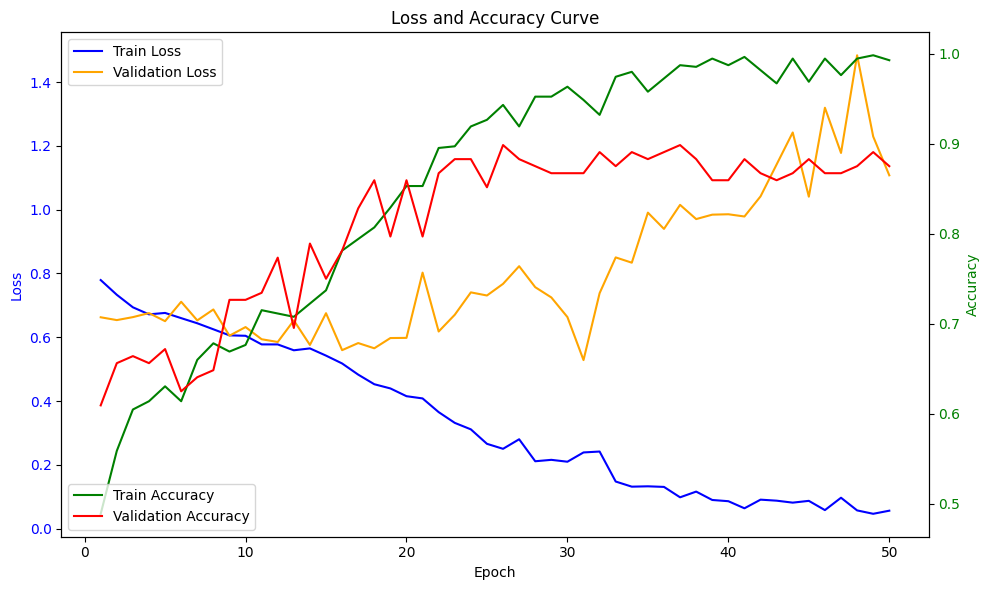

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn as nn

# 分类任务的损失函数
class_criterion = nn.CrossEntropyLoss()  # 分类任务的损失

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# 训练模型
num_epochs = 50

# 记录损失和准确率
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_class_loss = 0.0
    correct_class_preds = 0
    total_class_preds = 0
    
    # 使用 tqdm 包装 train_loader
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for tokens, class_labels in train_loader_tqdm:
        tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
        class_labels = class_labels.to(device)

        # 前向传播
        optimizer.zero_grad()
        class_output = model(tokens)

        # 计算分类任务的损失
        class_loss = class_criterion(class_output, class_labels)
        class_loss.backward()
        optimizer.step()

        running_class_loss += class_loss.item()

        # 计算分类准确率
        _, predicted = torch.max(class_output, 1)
        correct_class_preds += (predicted == class_labels).sum().item()
        total_class_preds += class_labels.size(0)

        # 在 tqdm 显示分类损失
        train_loader_tqdm.set_postfix({'Class Loss': class_loss.item()})

    avg_class_loss = running_class_loss / len(train_loader)
    train_accuracy = correct_class_preds / total_class_preds
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Class Loss: {avg_class_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 保存训练损失和准确率
    train_losses.append(avg_class_loss)
    train_accuracies.append(train_accuracy)

    # 验证模型
    model.eval()
    val_class_loss = 0.0
    correct_class_preds = 0
    total_class_preds = 0
    all_preds = []
    all_labels = []
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation")
    with torch.no_grad():
        for tokens, class_labels in val_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)

            # 前向传播
            class_output = model(tokens)

            # 计算分类任务的损失
            class_loss = class_criterion(class_output, class_labels)
            val_class_loss += class_loss.item()

            # 计算分类准确率
            _, predicted = torch.max(class_output, 1)
            correct_class_preds += (predicted == class_labels).sum().item()
            total_class_preds += class_labels.size(0)

        avg_val_class_loss = val_class_loss / len(val_loader)
        val_accuracy = correct_class_preds / total_class_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Class Loss: {avg_val_class_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # 保存验证损失和准确率
        val_losses.append(avg_val_class_loss)
        val_accuracies.append(val_accuracy)

import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

# 显示图形
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager
# 指定字体路径
font_path = './times.ttf'
prop = font_manager.FontProperties(fname=font_path)


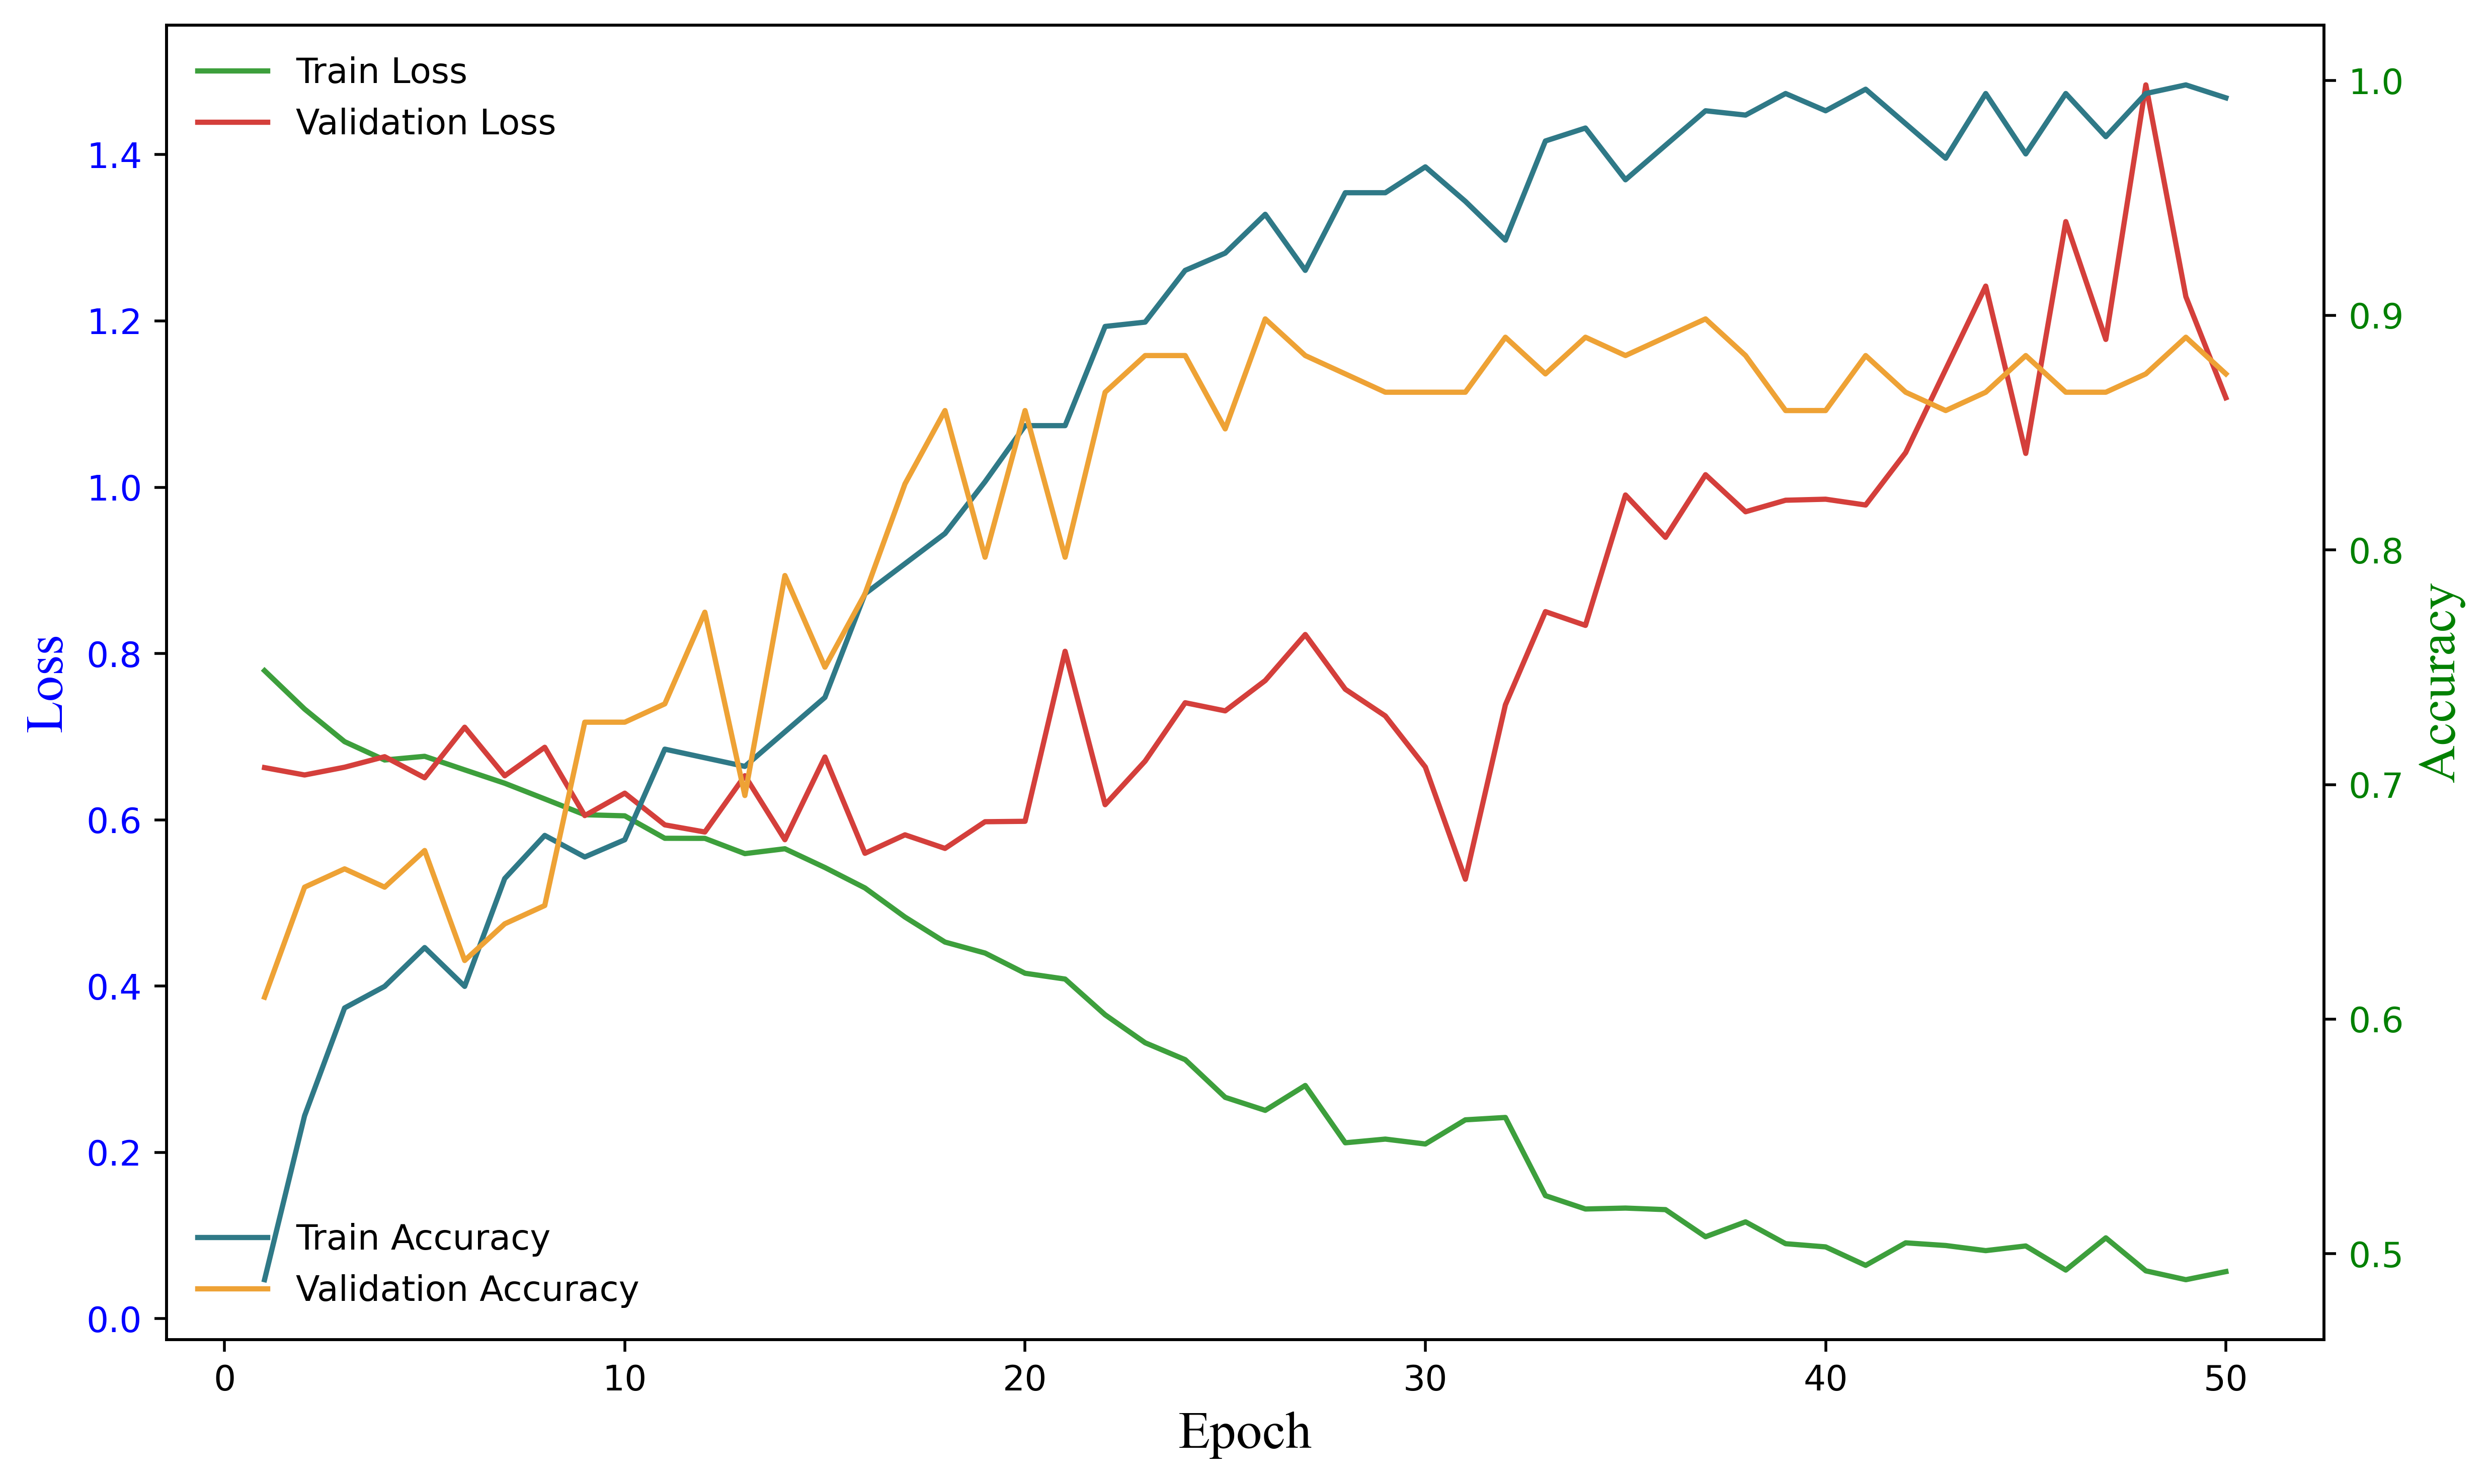

In [36]:
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6),dpi=500)

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='#3D9F3C')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='#D43F3B')
ax1.set_xlabel('Epoch',fontproperties=prop, fontsize=15)
ax1.set_ylabel('Loss', color='blue',fontproperties=prop, fontsize=15)
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
#ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='#2F7987')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='#EEA235')
ax2.set_ylabel('Accuracy', color='green',fontproperties=prop, fontsize=15)
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left', frameon=False,, fontsize=15)
ax2.legend(loc='lower left', frameon=False,, fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

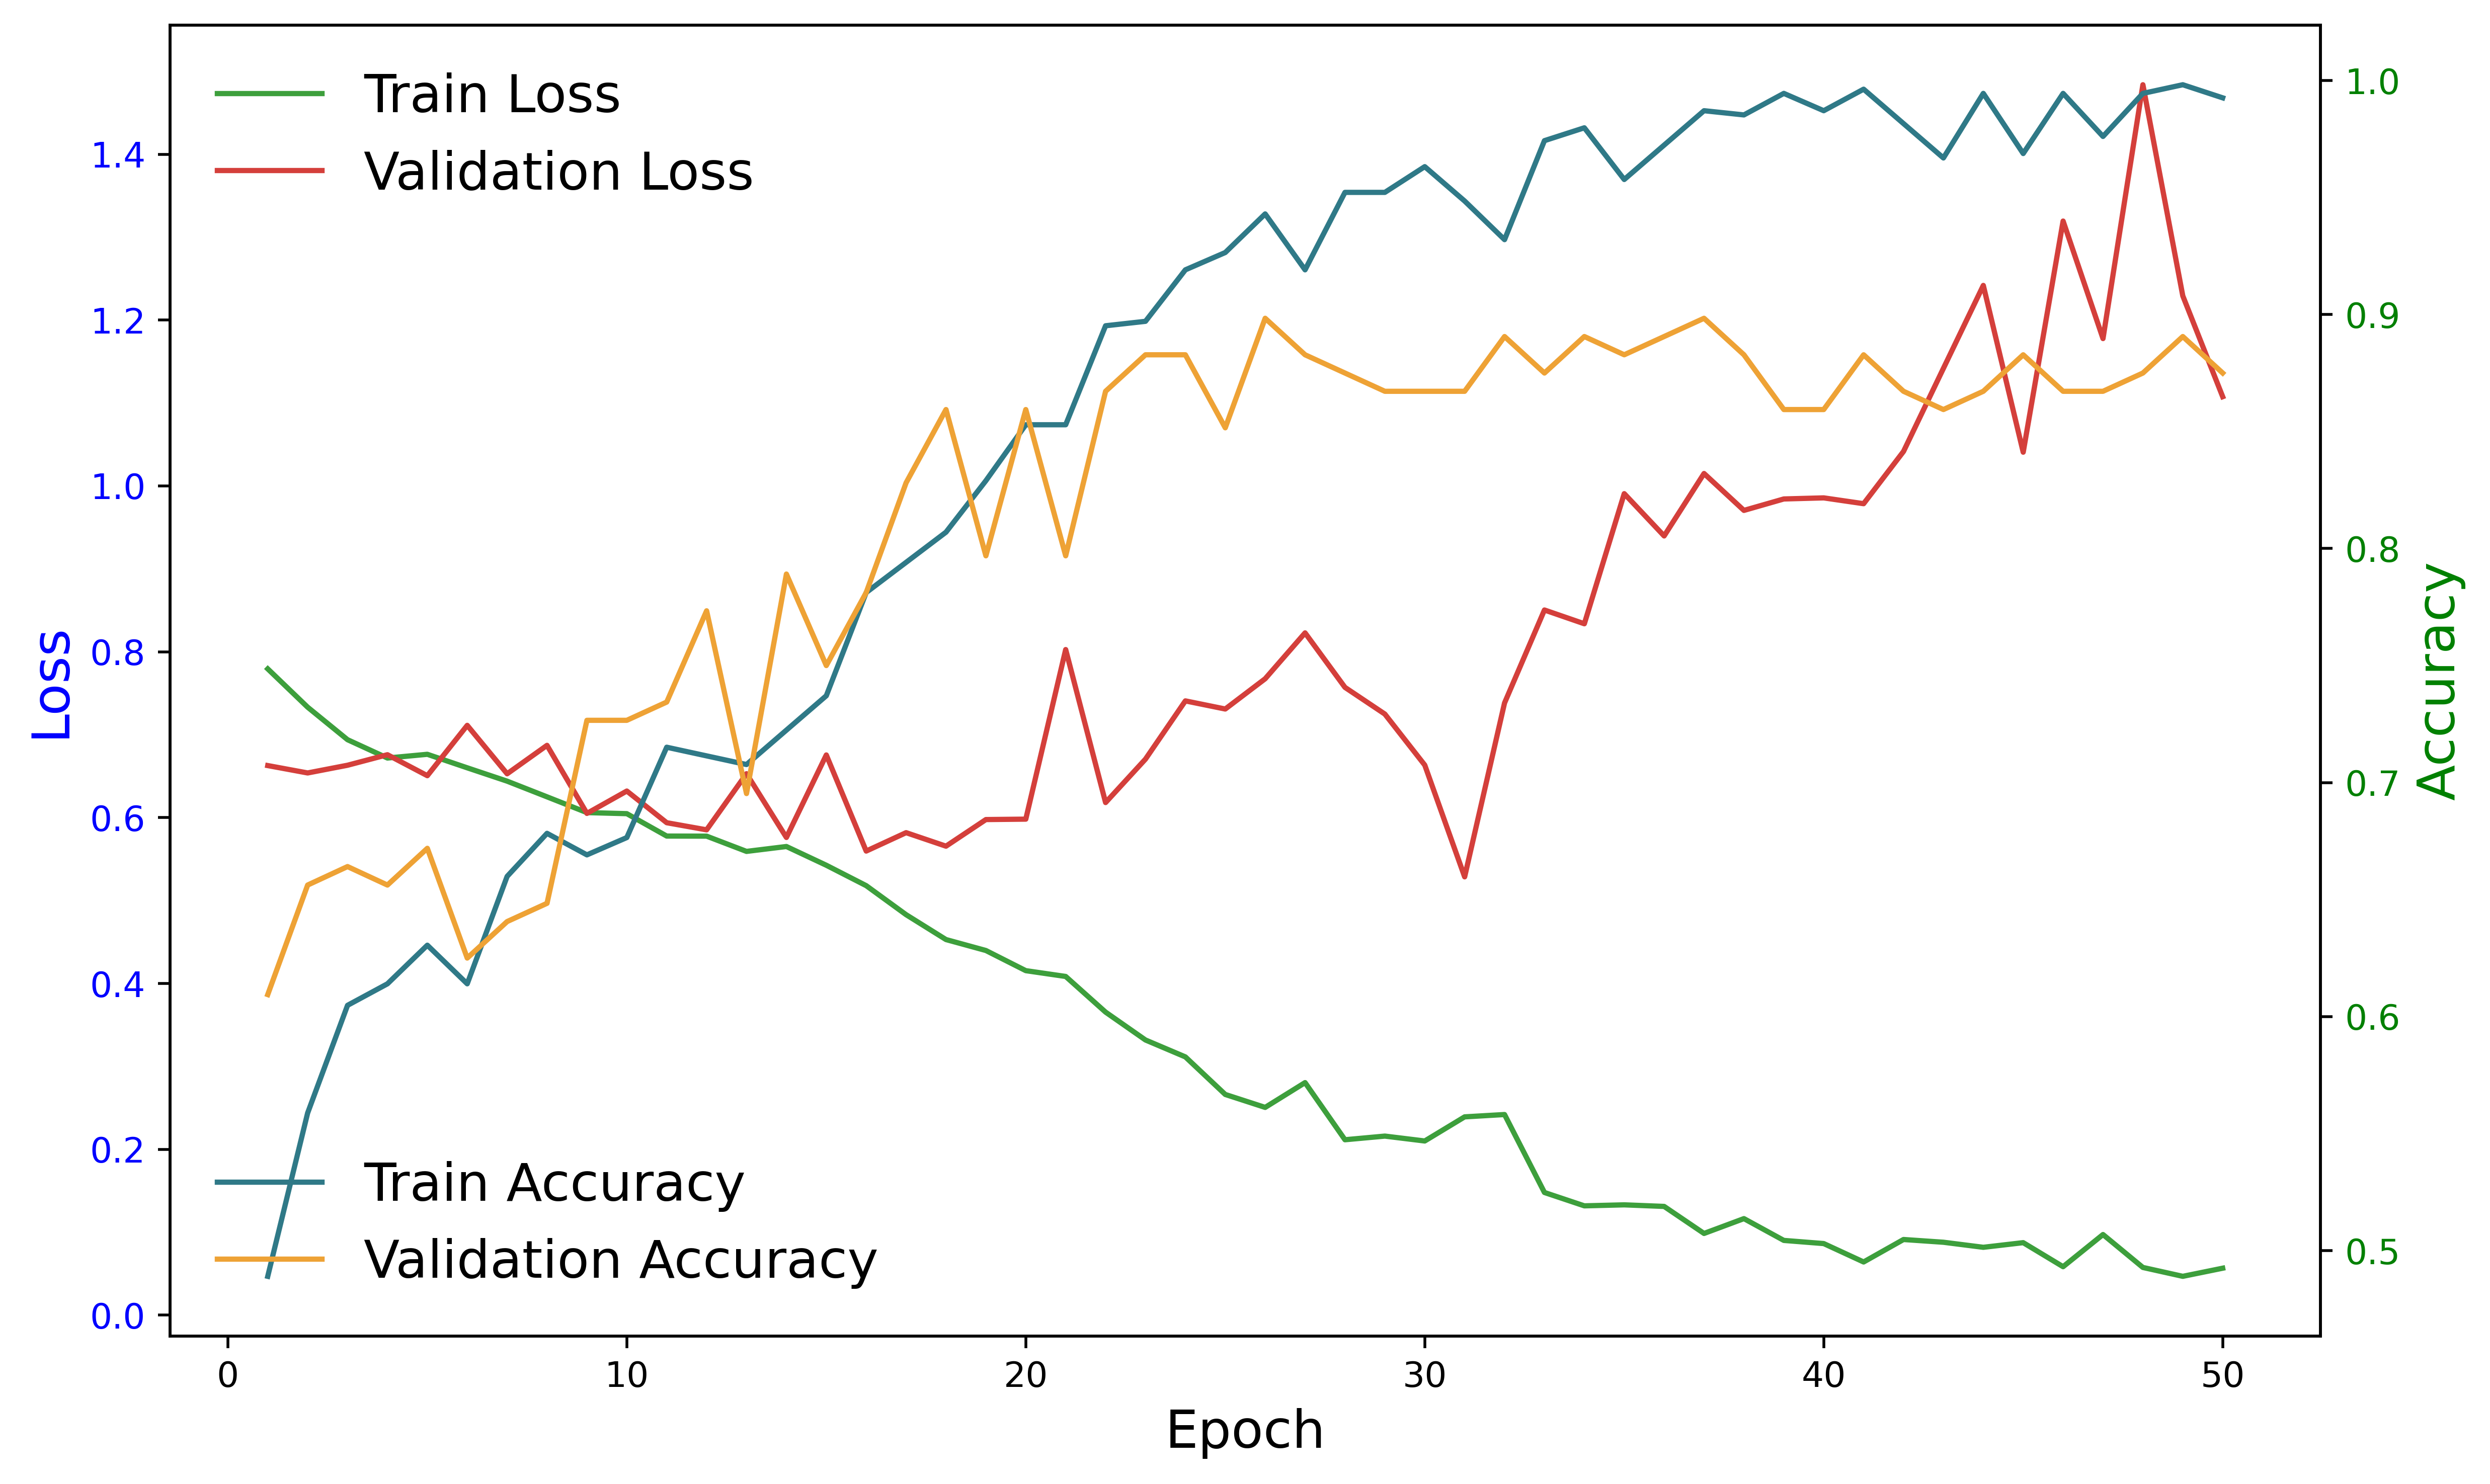

In [20]:
# 读取保存的CSV文件
df = pd.read_csv('training_metrics.csv')

# 提取数据
num_epochs = 50
train_losses = df['Train Loss']
val_losses = df['Val Loss']
train_accuracies = df['Train Accuracy']
val_accuracies = df['Val Accuracy']

import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6),dpi=500)

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='#3D9F3C')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='#D43F3B')
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_ylabel('Loss', color='blue', fontsize=15)
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
#ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='#2F7987')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='#EEA235')
ax2.set_ylabel('Accuracy', color='green', fontsize=15)
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left', frameon=False,fontsize=15)
ax2.legend(loc='lower left', frameon=False,fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

In [22]:
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies
})

# 将DataFrame保存为CSV文件
df.to_csv('training_metrics.csv', index=False)

In [15]:
import re
import pandas as pd

# 这里假设训练输出是一个多行字符串，包含训练的日志
output = """Epoch [1/50] - Training: 100%|██████████| 17/17 [00:02<00:00,  7.33it/s, Class Loss=0.68] 
Epoch [1/50], Train Class Loss: 0.7794, Train Accuracy: 0.4890
Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.68it/s]
Epoch [1/50], Val Class Loss: 0.6628, Val Accuracy: 0.6094
Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.77it/s, Class Loss=0.784]
Epoch [2/50], Train Class Loss: 0.7332, Train Accuracy: 0.5588
Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.59it/s]
Epoch [2/50], Val Class Loss: 0.6539, Val Accuracy: 0.6562
Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.88it/s, Class Loss=0.849]
Epoch [3/50], Train Class Loss: 0.6940, Train Accuracy: 0.6048
Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.62it/s]
Epoch [3/50], Val Class Loss: 0.6632, Val Accuracy: 0.6641
Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.75it/s, Class Loss=0.766]
Epoch [4/50], Train Class Loss: 0.6719, Train Accuracy: 0.6140
Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.42it/s]
Epoch [4/50], Val Class Loss: 0.6759, Val Accuracy: 0.6562
Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.93it/s, Class Loss=0.684]
Epoch [5/50], Train Class Loss: 0.6764, Train Accuracy: 0.6305
Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.73it/s]
Epoch [5/50], Val Class Loss: 0.6506, Val Accuracy: 0.6719
Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.76it/s, Class Loss=0.707]
Epoch [6/50], Train Class Loss: 0.6601, Train Accuracy: 0.6140
Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.82it/s]
Epoch [6/50], Val Class Loss: 0.7113, Val Accuracy: 0.6250
Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.69it/s, Class Loss=0.709]
Epoch [7/50], Train Class Loss: 0.6440, Train Accuracy: 0.6599
Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.70it/s]
Epoch [7/50], Val Class Loss: 0.6529, Val Accuracy: 0.6406
Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s, Class Loss=0.68] 
Epoch [8/50], Train Class Loss: 0.6251, Train Accuracy: 0.6783
Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.90it/s]
Epoch [8/50], Val Class Loss: 0.6872, Val Accuracy: 0.6484
Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.543]
Epoch [9/50], Train Class Loss: 0.6061, Train Accuracy: 0.6691
Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.06it/s]
Epoch [9/50], Val Class Loss: 0.6051, Val Accuracy: 0.7266
Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.68it/s, Class Loss=0.551]
Epoch [10/50], Train Class Loss: 0.6048, Train Accuracy: 0.6765
Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.80it/s]
Epoch [10/50], Val Class Loss: 0.6321, Val Accuracy: 0.7266
Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.84it/s, Class Loss=0.516]
Epoch [11/50], Train Class Loss: 0.5778, Train Accuracy: 0.7151
Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.48it/s]
Epoch [11/50], Val Class Loss: 0.5939, Val Accuracy: 0.7344
Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.586]
Epoch [12/50], Train Class Loss: 0.5777, Train Accuracy: 0.7114
Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.61it/s]
Epoch [12/50], Val Class Loss: 0.5853, Val Accuracy: 0.7734
Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.474]
Epoch [13/50], Train Class Loss: 0.5593, Train Accuracy: 0.7077
Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.41it/s]
Epoch [13/50], Val Class Loss: 0.6530, Val Accuracy: 0.6953
Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.545]
Epoch [14/50], Train Class Loss: 0.5652, Train Accuracy: 0.7224
Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.86it/s]
Epoch [14/50], Val Class Loss: 0.5761, Val Accuracy: 0.7891
Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.464]
Epoch [15/50], Train Class Loss: 0.5426, Train Accuracy: 0.7371
Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.14it/s]
Epoch [15/50], Val Class Loss: 0.6756, Val Accuracy: 0.7500
Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.56it/s, Class Loss=0.576]
Epoch [16/50], Train Class Loss: 0.5180, Train Accuracy: 0.7812
Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.52it/s]
Epoch [16/50], Val Class Loss: 0.5597, Val Accuracy: 0.7812
Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.52] 
Epoch [17/50], Train Class Loss: 0.4830, Train Accuracy: 0.7941
Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.91it/s]
Epoch [17/50], Val Class Loss: 0.5819, Val Accuracy: 0.8281
Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.395]
Epoch [18/50], Train Class Loss: 0.4530, Train Accuracy: 0.8070
Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.38it/s]
Epoch [18/50], Val Class Loss: 0.5656, Val Accuracy: 0.8594
Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.58it/s, Class Loss=0.363]
Epoch [19/50], Train Class Loss: 0.4398, Train Accuracy: 0.8290
Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.56it/s]
Epoch [19/50], Val Class Loss: 0.5977, Val Accuracy: 0.7969
Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s, Class Loss=0.276]
Epoch [20/50], Train Class Loss: 0.4155, Train Accuracy: 0.8529
Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.01it/s]
Epoch [20/50], Val Class Loss: 0.5982, Val Accuracy: 0.8594
Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.679]
Epoch [21/50], Train Class Loss: 0.4085, Train Accuracy: 0.8529
Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.63it/s]
Epoch [21/50], Val Class Loss: 0.8027, Val Accuracy: 0.7969
Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s, Class Loss=0.237]
Epoch [22/50], Train Class Loss: 0.3655, Train Accuracy: 0.8952
Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.40it/s]
Epoch [22/50], Val Class Loss: 0.6182, Val Accuracy: 0.8672
Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.179]
Epoch [23/50], Train Class Loss: 0.3319, Train Accuracy: 0.8971
Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.57it/s]
Epoch [23/50], Val Class Loss: 0.6706, Val Accuracy: 0.8828
Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.69it/s, Class Loss=0.37] 
Epoch [24/50], Train Class Loss: 0.3115, Train Accuracy: 0.9191
Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.61it/s]
Epoch [24/50], Val Class Loss: 0.7408, Val Accuracy: 0.8828
Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.64it/s, Class Loss=0.213] 
Epoch [25/50], Train Class Loss: 0.2662, Train Accuracy: 0.9265
Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.46it/s]
Epoch [25/50], Val Class Loss: 0.7310, Val Accuracy: 0.8516
Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.52it/s, Class Loss=0.211]
Epoch [26/50], Train Class Loss: 0.2506, Train Accuracy: 0.9430
Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.69it/s]
Epoch [26/50], Val Class Loss: 0.7675, Val Accuracy: 0.8984
Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.241]
Epoch [27/50], Train Class Loss: 0.2805, Train Accuracy: 0.9191
Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.86it/s]
Epoch [27/50], Val Class Loss: 0.8228, Val Accuracy: 0.8828
Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.62it/s, Class Loss=0.188] 
Epoch [28/50], Train Class Loss: 0.2116, Train Accuracy: 0.9522
Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.27it/s]
Epoch [28/50], Val Class Loss: 0.7571, Val Accuracy: 0.8750
Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.239] 
Epoch [29/50], Train Class Loss: 0.2160, Train Accuracy: 0.9522
Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.27it/s]
Epoch [29/50], Val Class Loss: 0.7249, Val Accuracy: 0.8672
Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.212] 
Epoch [30/50], Train Class Loss: 0.2101, Train Accuracy: 0.9632
Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.49it/s]
Epoch [30/50], Val Class Loss: 0.6634, Val Accuracy: 0.8672
Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0763]
Epoch [31/50], Train Class Loss: 0.2392, Train Accuracy: 0.9485
Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.36it/s]
Epoch [31/50], Val Class Loss: 0.5286, Val Accuracy: 0.8672
Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.111] 
Epoch [32/50], Train Class Loss: 0.2420, Train Accuracy: 0.9320
Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.86it/s]
Epoch [32/50], Val Class Loss: 0.7383, Val Accuracy: 0.8906
Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s, Class Loss=0.0698]
Epoch [33/50], Train Class Loss: 0.1480, Train Accuracy: 0.9743
Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.38it/s]
Epoch [33/50], Val Class Loss: 0.8504, Val Accuracy: 0.8750
Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0407]
Epoch [34/50], Train Class Loss: 0.1319, Train Accuracy: 0.9798
Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.75it/s]
Epoch [34/50], Val Class Loss: 0.8338, Val Accuracy: 0.8906
Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0418]
Epoch [35/50], Train Class Loss: 0.1331, Train Accuracy: 0.9577
Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.65it/s]
Epoch [35/50], Val Class Loss: 0.9907, Val Accuracy: 0.8828
Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.60it/s, Class Loss=0.0293]
Epoch [36/50], Train Class Loss: 0.1312, Train Accuracy: 0.9724
Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.73it/s]
Epoch [36/50], Val Class Loss: 0.9397, Val Accuracy: 0.8906
Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.75it/s, Class Loss=0.0309] 
Epoch [37/50], Train Class Loss: 0.0986, Train Accuracy: 0.9871
Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.31it/s]
Epoch [37/50], Val Class Loss: 1.0150, Val Accuracy: 0.8984
Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.76it/s, Class Loss=0.195] 
Epoch [38/50], Train Class Loss: 0.1165, Train Accuracy: 0.9853
Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.98it/s]
Epoch [38/50], Val Class Loss: 0.9705, Val Accuracy: 0.8828
Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.74it/s, Class Loss=0.0178]
Epoch [39/50], Train Class Loss: 0.0902, Train Accuracy: 0.9945
Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 26.62it/s]
Epoch [39/50], Val Class Loss: 0.9843, Val Accuracy: 0.8594
Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s, Class Loss=0.0522]
Epoch [40/50], Train Class Loss: 0.0864, Train Accuracy: 0.9871
Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.20it/s]
Epoch [40/50], Val Class Loss: 0.9856, Val Accuracy: 0.8594
Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.61it/s, Class Loss=0.0121]
Epoch [41/50], Train Class Loss: 0.0642, Train Accuracy: 0.9963
Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.36it/s]
Epoch [41/50], Val Class Loss: 0.9786, Val Accuracy: 0.8828
Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.70it/s, Class Loss=0.0585] 
Epoch [42/50], Train Class Loss: 0.0913, Train Accuracy: 0.9816
Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.83it/s]
Epoch [42/50], Val Class Loss: 1.0416, Val Accuracy: 0.8672
Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.0186]
Epoch [43/50], Train Class Loss: 0.0880, Train Accuracy: 0.9669
Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.60it/s]
Epoch [43/50], Val Class Loss: 1.1418, Val Accuracy: 0.8594
Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.71it/s, Class Loss=0.163] 
Epoch [44/50], Train Class Loss: 0.0819, Train Accuracy: 0.9945
Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.32it/s]
Epoch [44/50], Val Class Loss: 1.2418, Val Accuracy: 0.8672
Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.0121] 
Epoch [45/50], Train Class Loss: 0.0875, Train Accuracy: 0.9688
Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.32it/s]
Epoch [45/50], Val Class Loss: 1.0407, Val Accuracy: 0.8828
Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s, Class Loss=0.127] 
Epoch [46/50], Train Class Loss: 0.0585, Train Accuracy: 0.9945
Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 27.90it/s]
Epoch [46/50], Val Class Loss: 1.3194, Val Accuracy: 0.8672
Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.61it/s, Class Loss=0.07]  
Epoch [47/50], Train Class Loss: 0.0973, Train Accuracy: 0.9761
Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 28.86it/s]
Epoch [47/50], Val Class Loss: 1.1777, Val Accuracy: 0.8672
Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.57it/s, Class Loss=0.0602] 
Epoch [48/50], Train Class Loss: 0.0576, Train Accuracy: 0.9945
Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.01it/s]
Epoch [48/50], Val Class Loss: 1.4838, Val Accuracy: 0.8750
Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s, Class Loss=0.146]  
Epoch [49/50], Train Class Loss: 0.0469, Train Accuracy: 0.9982
Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.48it/s]
Epoch [49/50], Val Class Loss: 1.2292, Val Accuracy: 0.8906
Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.62it/s, Class Loss=0.0607] 
Epoch [50/50], Train Class Loss: 0.0567, Train Accuracy: 0.9926
Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 29.29it/s]
Epoch [50/50], Val Class Loss: 1.1076, Val Accuracy: 0.8750
"""  # 这里是你的日志数据，你需要用真实的日志替换这部分

# 使用正则表达式提取数据
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 正则表达式用于提取训练数据
train_pattern = re.compile(r'Epoch \[(\d+/\d+)\], Train Class Loss: ([\d\.]+), Train Accuracy: ([\d\.]+)')
val_pattern = re.compile(r'Epoch \[(\d+/\d+)\], Val Class Loss: ([\d\.]+), Val Accuracy: ([\d\.]+)')

for line in output.split("\n"):
    # 匹配训练数据
    match_train = train_pattern.search(line)
    if match_train:
        epoch = match_train.group(1)
        train_loss = float(match_train.group(2))
        train_accuracy = float(match_train.group(3))
        epochs.append(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

    # 匹配验证数据
    match_val = val_pattern.search(line)
    if match_val:
        val_loss = float(match_val.group(2))
        val_accuracy = float(match_val.group(3))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

# 将数据保存到DataFrame
df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies
})

# 将DataFrame保存为CSV文件
df.to_csv('training_metrics.csv', index=False)

# 输出保存的DataFrame
print(df)

    Epoch  Train Loss  Val Loss  Train Accuracy  Val Accuracy
0    1/50      0.7794    0.6628          0.4890        0.6094
1    2/50      0.7332    0.6539          0.5588        0.6562
2    3/50      0.6940    0.6632          0.6048        0.6641
3    4/50      0.6719    0.6759          0.6140        0.6562
4    5/50      0.6764    0.6506          0.6305        0.6719
5    6/50      0.6601    0.7113          0.6140        0.6250
6    7/50      0.6440    0.6529          0.6599        0.6406
7    8/50      0.6251    0.6872          0.6783        0.6484
8    9/50      0.6061    0.6051          0.6691        0.7266
9   10/50      0.6048    0.6321          0.6765        0.7266
10  11/50      0.5778    0.5939          0.7151        0.7344
11  12/50      0.5777    0.5853          0.7114        0.7734
12  13/50      0.5593    0.6530          0.7077        0.6953
13  14/50      0.5652    0.5761          0.7224        0.7891
14  15/50      0.5426    0.6756          0.7371        0.7500
15  16/5

In [13]:
torch.save(model.state_dict(), 'best_chemberta_model.pth')

In [14]:
# 加载最佳模型
model.load_state_dict(torch.load('./best_chemberta_model.pth'))

<All keys matched successfully>

In [16]:


# 提取 SMILES 的嵌入表示

# 提取 SMILES 的嵌入表示
def extract_embeddings(smiles_list, model, tokenizer, device):
    embeddings = []
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        for smiles in smiles_list:
            # Tokenize the SMILES string
            tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            
            # 通过 ChemBERTa 模型获得输出
            outputs = model.chemberta(**tokens)  # 提取 ChemBERTa 模型的输出
            
            # 提取 [CLS] token 的嵌入作为 SMILES 的整体嵌入
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # 获取多维的 [CLS] 嵌入
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)  # 将所有嵌入拼接成一个矩阵

# 提取嵌入
smiles_embeddings = extract_embeddings(smiles_data, model, tokenizer, device)

In [8]:
smiles_embeddings=np.load('./Toxicity_smiles_embeddings.npy')

In [11]:
from matplotlib import font_manager
# 指定字体路径
font_path = '../front/times.ttf'
prop = font_manager.FontProperties(fname=font_path)

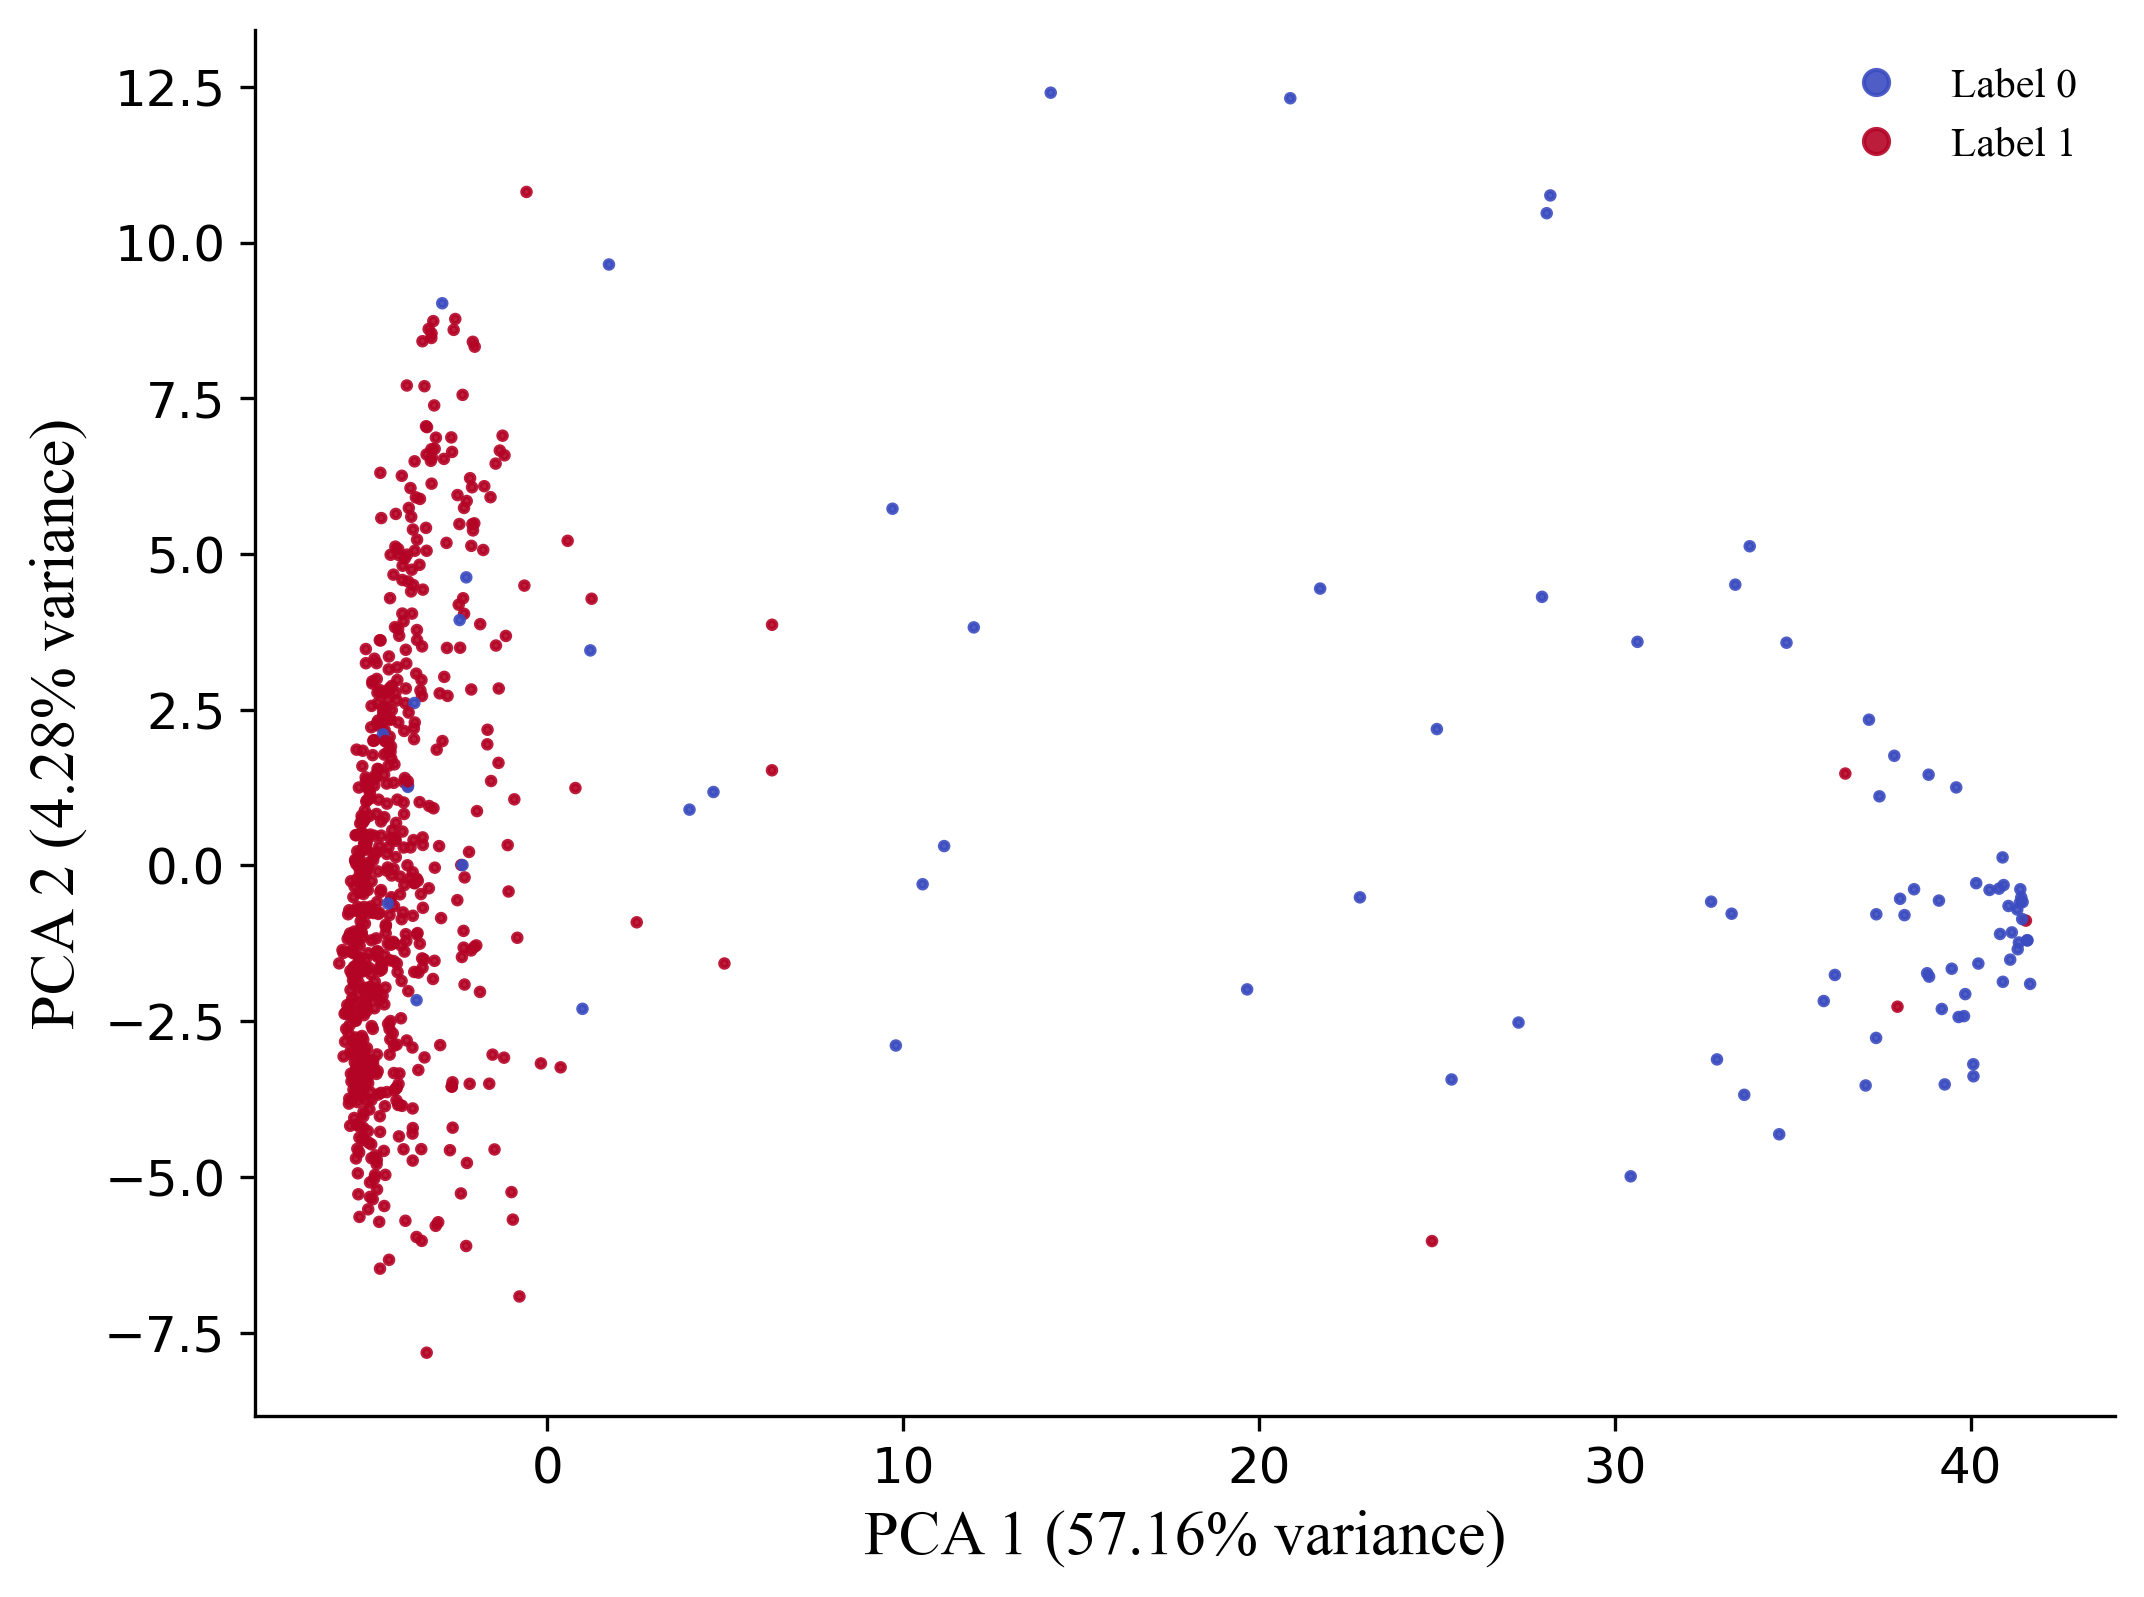

In [12]:
# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance


# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15, fontproperties=prop)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15, fontproperties=prop)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=20,frameon=False, prop=prop)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()



# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

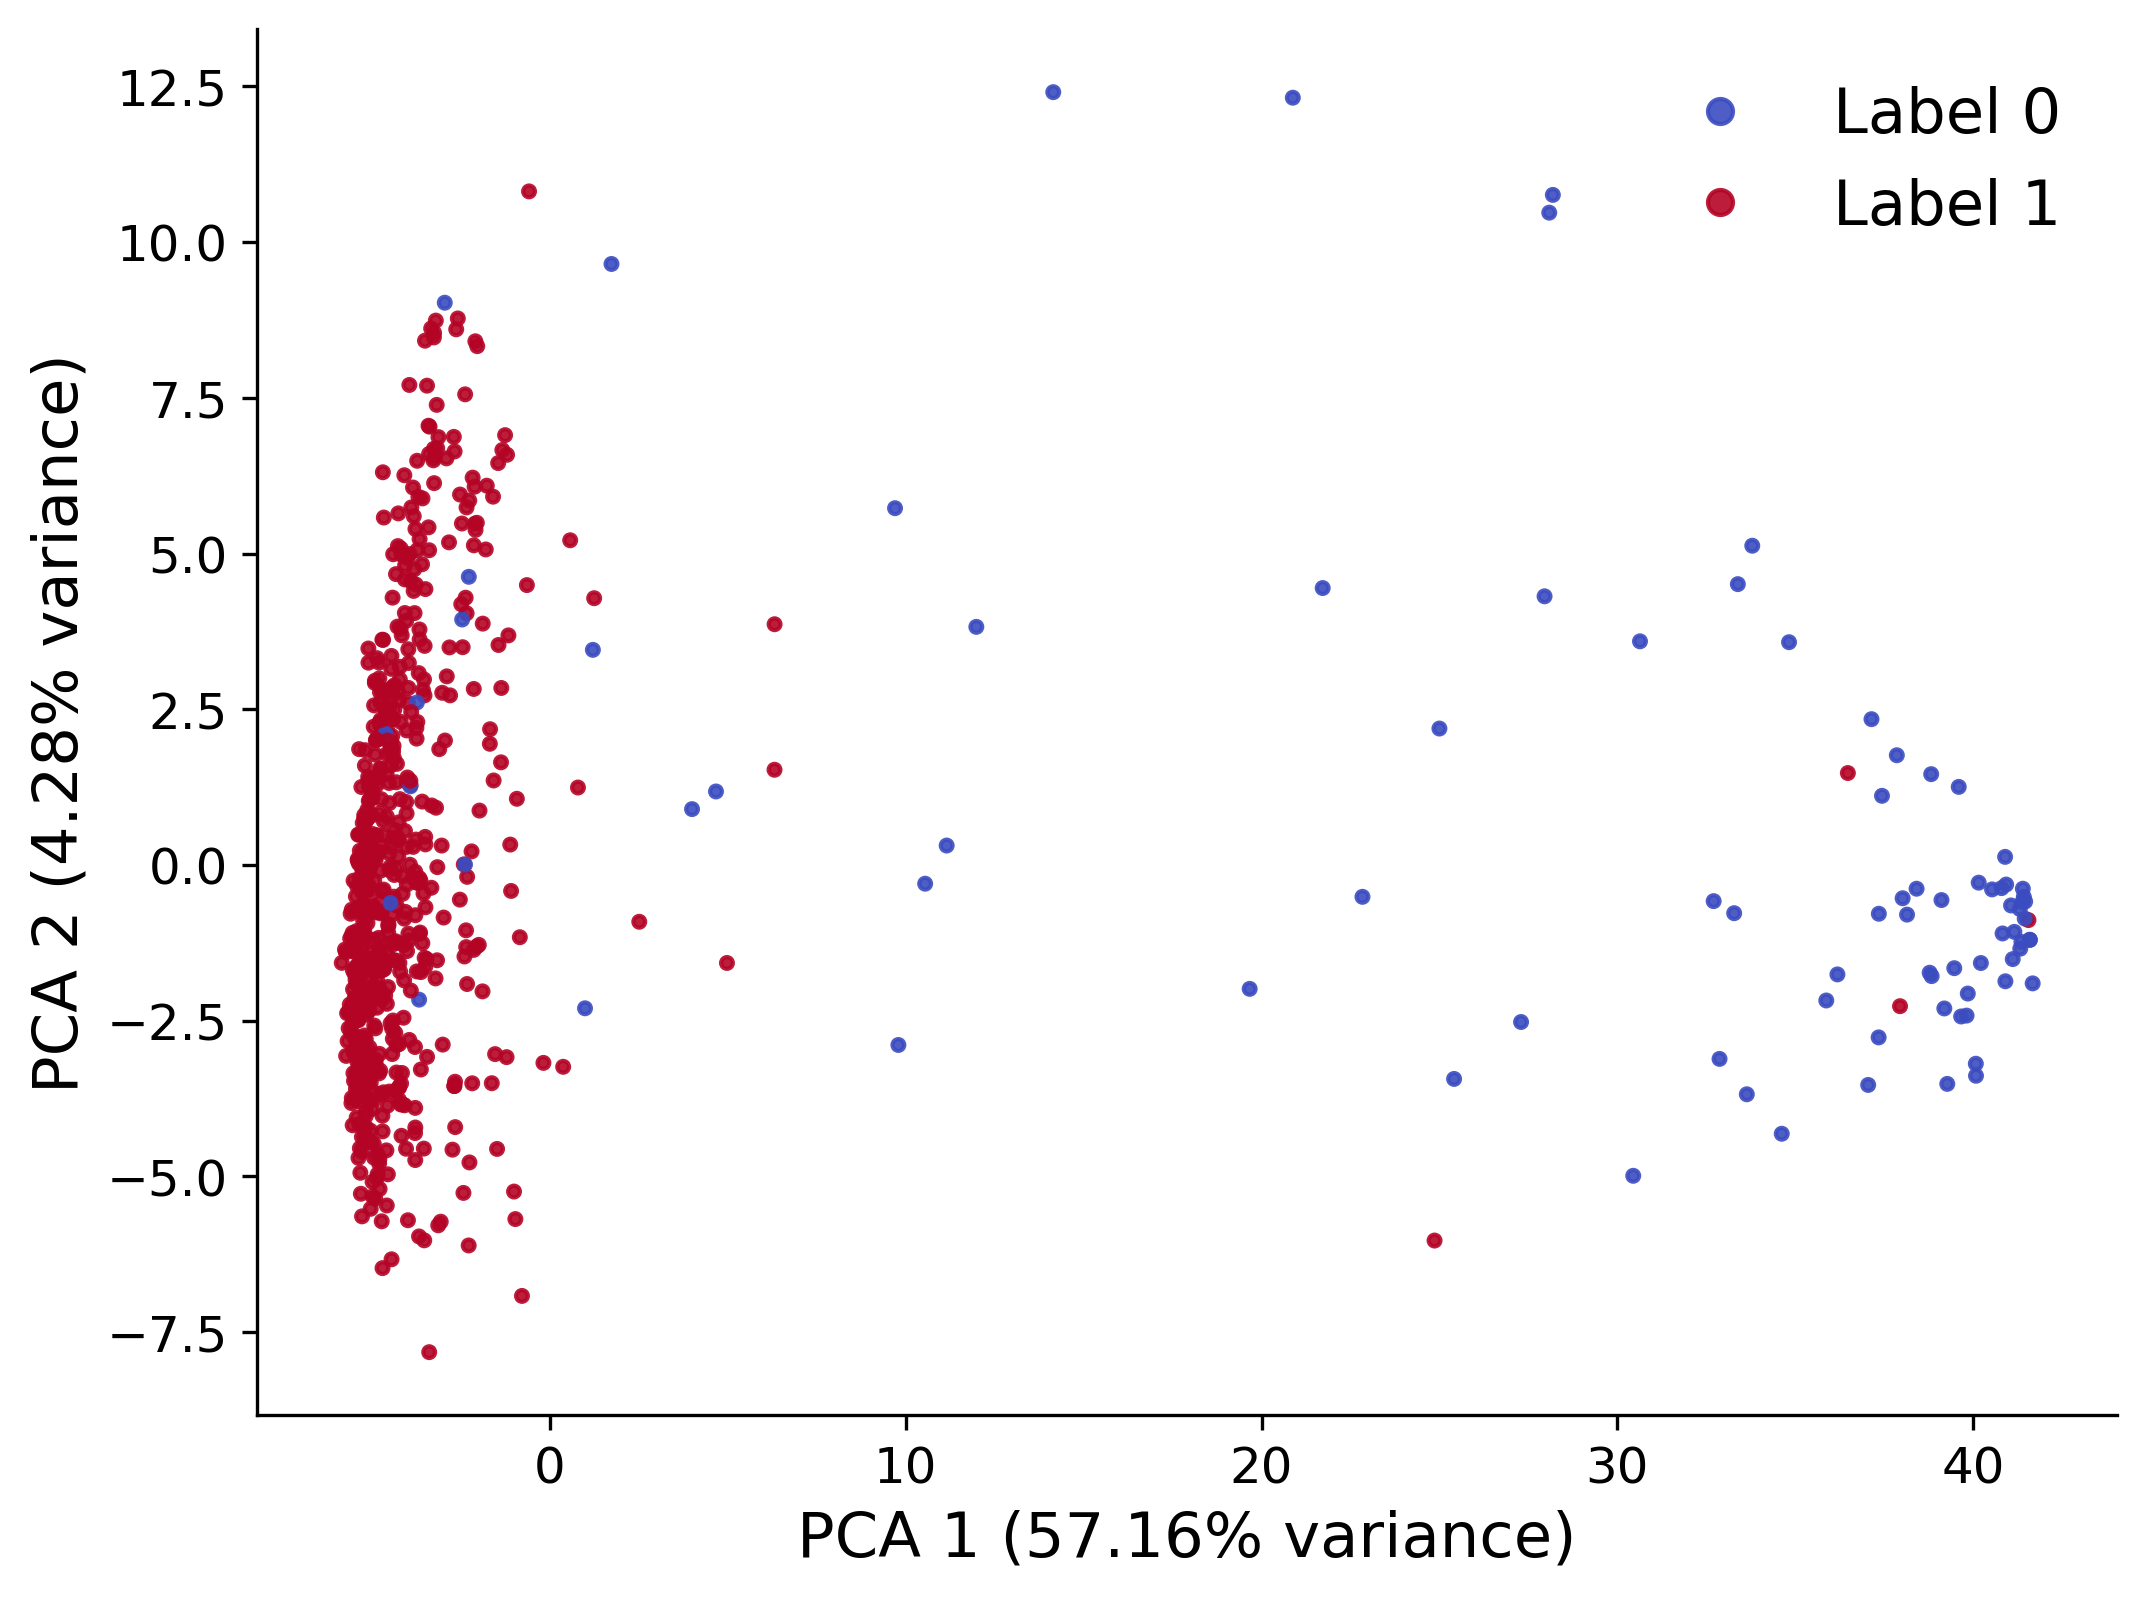

In [25]:
# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()


# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

In [ ]:
# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()

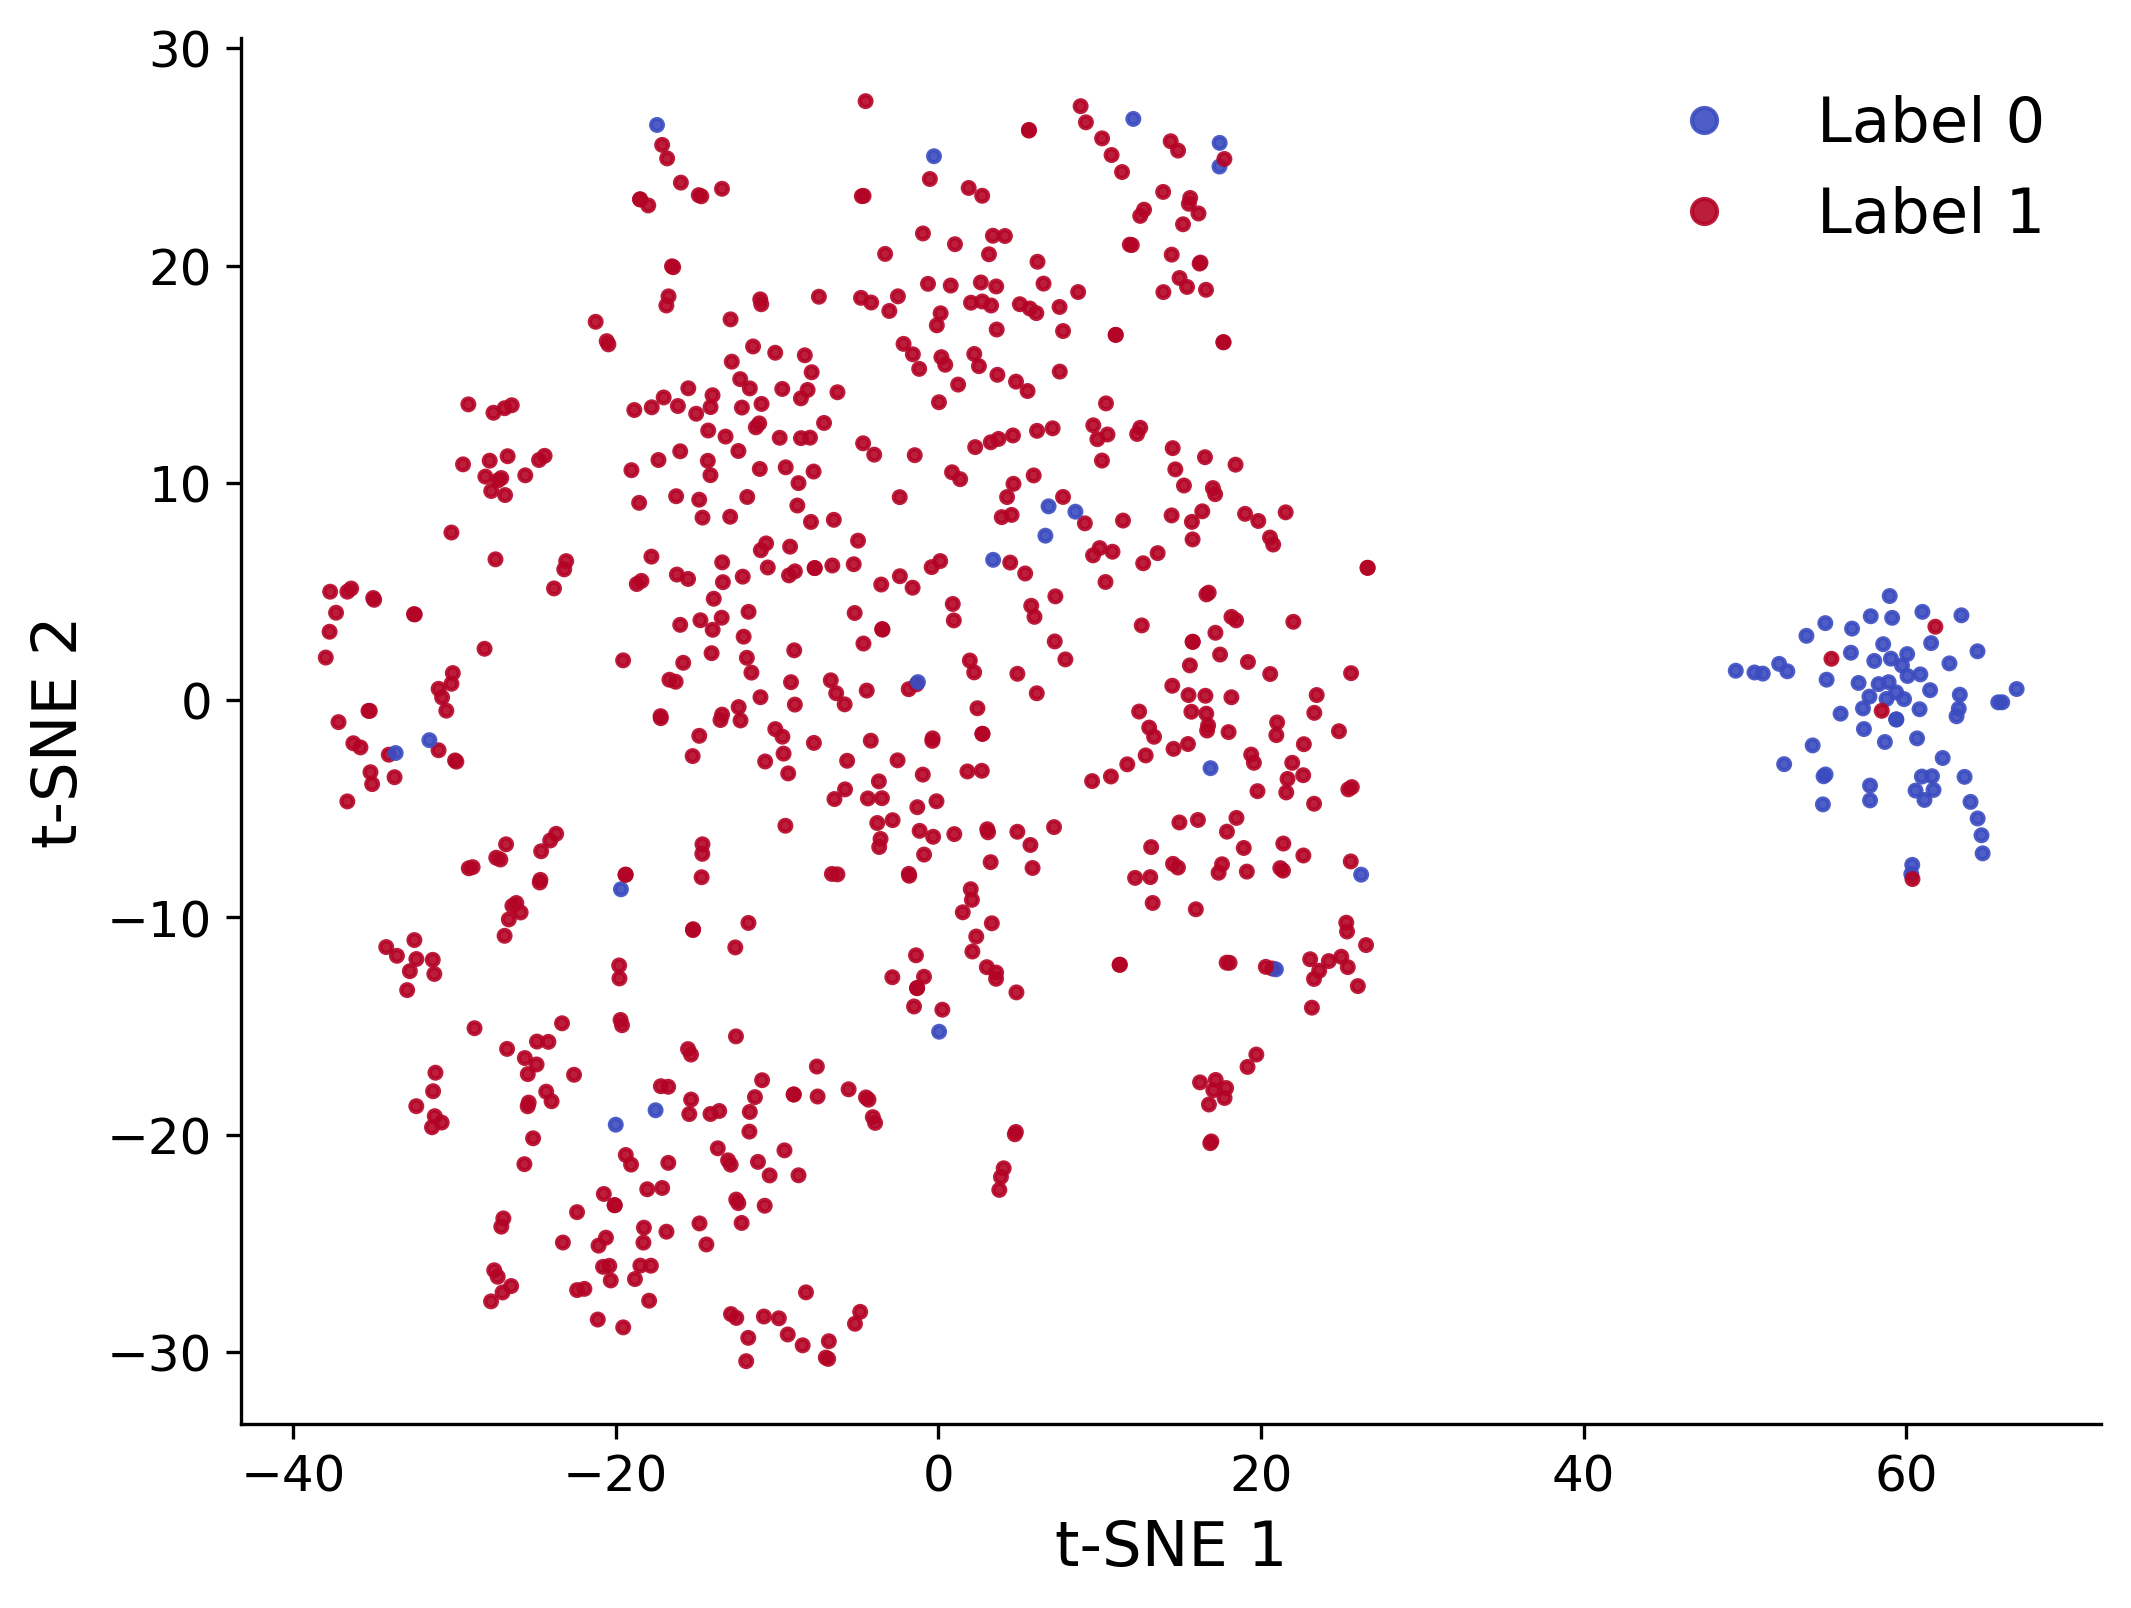

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import font_manager



# 使用 t-SNE 对嵌入进行降维，同时获取每个主成分的解释方差百分比
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def plot_tsne_with_variance(tsne_result, labels):
    plt.figure(figsize=(8, 6),dpi=300)
    
    # 绘制散点图，使用 'coolwarm' colormap，labels 作为着色依据
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    # 添加 colorbar
    #cbar = plt.colorbar(scatter)
    #cbar.set_label('lables', fontsize=15, fontproperties=prop)  # 设置 colorbar 的字体大小
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 设置坐标轴标签
    plt.xlabel('t-SNE 1', fontsize=15)
    plt.ylabel('t-SNE 2', fontsize=15)

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 显示左侧框线
    ax.spines['right'].set_visible(False)  # 显示底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    # 显示图形
    plt.show()




# 使用 t-SNE 降维
tsne_result = apply_tsne(smiles_embeddings, n_components=2)

# 绘制 t-SNE 图
plot_tsne_with_variance(tsne_result, labels)


In [21]:
np.save('./CLS_smiles_embeddings.npy', smiles_embeddings)

In [14]:
smiles_embeddings.shape

(708, 768)

In [24]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve




y = labels
X = smiles_embeddings


# 训练和评估函数
def train_evaluate_model_with_optuna(model_name, model_class, param_func, X_train, y_train,X_test,y_test):
    def objective(trial):
        params = param_func(trial)
        if model_class == SVC:
            params['probability'] = True

        model = model_class(**params)
        pr_auc_scores = []

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        

        return pr_auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print(f'Best parameters for {model_name}: {study.best_params}')
    best_params = study.best_params
    if model_class == SVC:
        best_params['probability'] = True

    # 使用最优超参数训练最优模型
    best_model = model_class(**best_params)
    best_model.fit(X_train, y_train)

    model_save_path="./best_xgb.joblib"
    joblib.dump(best_model, model_save_path)  # 保存模型



def xgb_param_func(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }



In [20]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

In [21]:
print("Training XGBoost...")
train_evaluate_model_with_optuna("XGBoost", XGBClassifier, xgb_param_func, X_train, y_train, X_test,y_test)

[I 2025-02-22 15:09:30,979] A new study created in memory with name: no-name-aceebaae-9a3c-45cc-ab3a-8b748763be20


Training XGBoost...


[I 2025-02-22 15:09:32,541] Trial 0 finished with value: 0.9999362539682541 and parameters: {'n_estimators': 484, 'max_depth': 1, 'learning_rate': 0.07998534314009868}. Best is trial 0 with value: 0.9999362539682541.
[I 2025-02-22 15:09:33,225] Trial 1 finished with value: 0.9999362539682539 and parameters: {'n_estimators': 24, 'max_depth': 23, 'learning_rate': 0.02195345834503642}. Best is trial 0 with value: 0.9999362539682541.
[I 2025-02-22 15:09:42,085] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 813, 'max_depth': 43, 'learning_rate': 0.02436317902902763}. Best is trial 2 with value: 1.0.
[I 2025-02-22 15:09:51,968] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 920, 'max_depth': 17, 'learning_rate': 0.01874223361338189}. Best is trial 2 with value: 1.0.
[I 2025-02-22 15:09:53,095] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 357, 'max_depth': 17, 'learning_rate': 0.7380425026122038}. Best is trial 2 with value: 1.0.
[I 

Best parameters for XGBoost: {'n_estimators': 813, 'max_depth': 43, 'learning_rate': 0.02436317902902763}


In [25]:
# 直接使用最优参数进行五折交叉验证
def train_evaluate_with_best_params(model_name, model_class, best_params, X, y):
    # 创建模型并设置最优参数
    model = model_class(**best_params)

    # 五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 存储各个折的评价指标
    metrics_train = {'PR-AUC': [], 'AU-ROC': [], 'ACC': [], 'PREC': [], 'REC': [], 'F1': []}
    metrics_test = {'PR-AUC': [], 'AU-ROC': [], 'ACC': [], 'PREC': [], 'REC': [], 'F1': []}
    
    # 使用 tqdm 包裹五折交叉验证的每一折
    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc=f"Training {model_name}")):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        
        # 训练集指标
        y_prob_train = model.predict_proba(X_train)[:, 1]
        precision_train, recall_train, _ = precision_recall_curve(y_train, y_prob_train)
        pr_auc_train = auc(recall_train, precision_train)
        metrics_train['PR-AUC'].append(pr_auc_train)

        fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
        auc_train = auc(fpr_train, tpr_train)
        metrics_train['AU-ROC'].append(auc_train)

        accuracy_train = accuracy_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['ACC'].append(accuracy_train)

        precision_train_val = precision_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['PREC'].append(precision_train_val)

        recall_train_val = recall_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['REC'].append(recall_train_val)

        f1_train_val = f1_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['F1'].append(f1_train_val)

        # 测试集指标
        y_prob_test = model.predict_proba(X_val)[:, 1]
        precision_test, recall_test, _ = precision_recall_curve(y_val, y_prob_test)
        pr_auc_test = auc(recall_test, precision_test)
        metrics_test['PR-AUC'].append(pr_auc_test)

        fpr_test, tpr_test, _ = roc_curve(y_val, y_prob_test)
        auc_test = auc(fpr_test, tpr_test)
        metrics_test['AU-ROC'].append(auc_test)

        accuracy_test = accuracy_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['ACC'].append(accuracy_test)

        precision_test_val = precision_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['PREC'].append(precision_test_val)

        recall_test_val = recall_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['REC'].append(recall_test_val)

        f1_test_val = f1_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['F1'].append(f1_test_val)

        # 输出当前折的训练集和测试集评价指标
        print(f"Fold {fold + 1} - Train metrics:")
        for metric, values in metrics_train.items():
            print(f"  {metric}: {values[-1]:.4f}")
        
        print(f"Fold {fold + 1} - Test metrics:")
        for metric, values in metrics_test.items():
            print(f"  {metric}: {values[-1]:.4f}")
        print()

        # 将训练集和测试集的结果合并成一个 DataFrame
    results = {
        'Metric': ['PR-AUC', 'AU-ROC', 'F1', 'REC', 'PREC', 'ACC'],
        'Train': [
            np.mean(metrics_train['PR-AUC']),
            np.mean(metrics_train['AU-ROC']),
            np.mean(metrics_train['F1']),
            np.mean(metrics_train['REC']),
            np.mean(metrics_train['PREC']),
            np.mean(metrics_train['ACC'])
        ],
        'Test': [
            np.mean(metrics_test['PR-AUC']),
            np.mean(metrics_test['AU-ROC']),
            np.mean(metrics_test['F1']),
            np.mean(metrics_test['REC']),
            np.mean(metrics_test['PREC']),
            np.mean(metrics_test['ACC'])
        ]
    }
    
    df_results = pd.DataFrame(results)

    # 保存结果到CSV文件
    df_results.to_csv(f'{model_name}_evaluation_metrics.csv', index=False)
    print(f"Metrics saved to {model_name}_evaluation_metrics.csv")




    
    # 输出每个评价指标的训练集和测试集平均值
    print(f'Average Train PR AUC: {np.mean(metrics_train["PR-AUC"]):.4f}')
    print(f'Average Test PR AUC: {np.mean(metrics_test["PR-AUC"]):.4f}')

    print(f'Average Train AU-ROC: {np.mean(metrics_train["AU-ROC"]):.4f}')
    print(f'Average Test AU-ROC: {np.mean(metrics_test["AU-ROC"]):.4f}')

    print(f'Average Train Accuracy: {np.mean(metrics_train["ACC"]):.4f}')
    print(f'Average Test Accuracy: {np.mean(metrics_test["ACC"]):.4f}')

    print(f'Average Train Precision: {np.mean(metrics_train["PREC"]):.4f}')
    print(f'Average Test Precision: {np.mean(metrics_test["PREC"]):.4f}')

    print(f'Average Train Recall: {np.mean(metrics_train["REC"]):.4f}')
    print(f'Average Test Recall: {np.mean(metrics_test["REC"]):.4f}')

    print(f'Average Train F1: {np.mean(metrics_train["F1"]):.4f}')
    print(f'Average Test F1: {np.mean(metrics_test["F1"]):.4f}')


In [30]:
import numpy as np
y = np.array(y)  # 将 y 转换为 NumPy 数组
print(y.shape)    # 现在你可以使用 .shape 属性


(708,)


In [32]:
import torch
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve


In [33]:
# 最优参数
best_params_xgb = {'n_estimators': 813, 'max_depth': 43, 'learning_rate': 0.02436317902902763,'eval_metric': 'error' }

# 训练并评估 XGBoost 模型
train_evaluate_with_best_params("XGBoost", XGBClassifier, best_params_xgb, X, y)

Training XGBoost:  20%|██        | 1/5 [00:08<00:32,  8.06s/it]

Fold 1 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 1 - Test metrics:
  PR-AUC: 0.9978
  AU-ROC: 0.9849
  ACC: 0.9789
  PREC: 0.9841
  REC: 0.9920
  F1: 0.9880



Training XGBoost:  40%|████      | 2/5 [00:14<00:21,  7.02s/it]

Fold 2 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 2 - Test metrics:
  PR-AUC: 0.9934
  AU-ROC: 0.9619
  ACC: 0.9648
  PREC: 0.9839
  REC: 0.9760
  F1: 0.9799



Training XGBoost:  60%|██████    | 3/5 [00:21<00:14,  7.17s/it]

Fold 3 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 3 - Test metrics:
  PR-AUC: 0.9965
  AU-ROC: 0.9780
  ACC: 0.9648
  PREC: 0.9685
  REC: 0.9919
  F1: 0.9801



Training XGBoost:  80%|████████  | 4/5 [00:28<00:06,  6.99s/it]

Fold 4 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 4 - Test metrics:
  PR-AUC: 0.9848
  AU-ROC: 0.9336
  ACC: 0.9716
  PREC: 0.9688
  REC: 1.0000
  F1: 0.9841



Training XGBoost: 100%|██████████| 5/5 [00:36<00:00,  7.22s/it]

Fold 5 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 5 - Test metrics:
  PR-AUC: 0.9996
  AU-ROC: 0.9972
  ACC: 0.9787
  PREC: 0.9764
  REC: 1.0000
  F1: 0.9880

Metrics saved to XGBoost_evaluation_metrics.csv
Average Train PR AUC: 1.0000
Average Test PR AUC: 0.9944
Average Train AU-ROC: 1.0000
Average Test AU-ROC: 0.9711
Average Train Accuracy: 1.0000
Average Test Accuracy: 0.9718
Average Train Precision: 1.0000
Average Test Precision: 0.9763
Average Train Recall: 1.0000
Average Test Recall: 0.9920
Average Train F1: 1.0000
Average Test F1: 0.9840


In [ ]:
#val_r2 = r2_score(np.expm1(all_labels), np.expm1(all_preds))  # 还原 log1p 的值